# Introduction



## Domain Background
- Social networks represent how entities connect and interact, forming complex structures of relationships.

- In the context of Facebook page-page networks, the nodes are public pages (companies, government orgs, politicians, TV shows) and edges represent mutual "likes" between them.

- These connections often reveal shared interests, topical similarity, or strategic alignment between pages. Studying such networks helps uncover communities, influence patterns, and hompohily, offering insights into how information and popularity spread across different categories of pages.

## Dataset Description

The dataset used in this project is the Facebook Large Page-Page Network from the Stanford Large Network Dataset Collection (SNAP). The network was collected through the Facebook Graph API in November 2017.

Dataset Info:

- 22,470 nodes (verified Facebook pages)
- 171,002 undirected edges (mutual 'likes' between pages)
- Four node labels (Facebook-defined categories) - supports multi-class node classficiation
    1. Politicians
    2. Government Organizations
    3. TV Shows
    4. Companies
- Node features extracted from site descriptions that the page owners created to summarize the purpose of the site.
- No edge features.

Citation:

- B. Rozemberczki, C. Allen and R. Sarkar. Multi-scale Attributed Node Embedding. 2019.


## Research Questions

1. Do Facebook pages tend to connect more often with other pages from the same category (e.g., politician-to-politician, brand-to-brand)?

2. Which Facebook pages connect different types of communities together (acting as structural bridges), and what kind of pages are they (e.g., media outlets, celebrities, organizations)?

3. Does the network show signs of structural balance — for example, do pages that both like a third page also tend to like each other?

# Methods

## Overview


Our analysis focused on three main aspects of the Page-Page network. First, we examined homophily, testing whether pages are more likely to connect with other in the same category. Then, we identified bridging pages that connect otherwise separate communities by analyzing centrality and community structure. Finally, we explored structural balance by checking whether pages that like same targets also tend to connect with each other. All the analyses were implemented in Julia using standard network analysis libraries and visualization tools.

### Computational Approach
  1. Data Preprocessing
      - Load data and drop self-loops/duplicate undirected edges.
      - Build an undirected simple graph
      - Keep/label nodes with missing category as “Unknown.”

  2. Homophily Analysis
      - Created a category-to-category mixing matrix.
      - Calculated assortativity to measure how often pages connect within same category.
      - Compared results to a random baseline by shuffling category labels.

  3. Structural Bridge Analysis
      - Applied community detection (Louvain/Leiden) to identify page clusters.
      - Calculated betweenness centrality and participation coefficients.
      - Highlighted pages with high cross-community connections as structural bridges.

  4. Structural Balance / Triadic Closure
      - Measured clustering and triangle formation across the network.
      - Calculated how often pages with common neighbors were also connected.
      - Compared closure levels to a random baseline.

## Data Preprocessing

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

In [12]:
# Data Preprocessing
include("src/preprocessing.jl")

data = NetworkPreprocessing.preprocess("data/musae_facebook_edges.csv",
                  "data/musae_facebook_target.csv",
                  "data/musae_facebook_features.json")

g            = data.g
labels       = data.labels
label_code   = data.label_code
label_levels = data.label_levels
X            = data.X
K            = data.K
targets_df   = data.targets_df
all_ids = data.all_ids
id2idx = data.id2idx;


## Data Description

In [7]:
include("src/Describe.jl")
using .Describe

Describe.describe_graph(g)

No. of Nodes in the Graph: 22470
No. of Edges in the Graph: 170823
Fraction of triangles that are closed: 0.23232143653859755
Percent of edges that are bridges: 1.7403979557787885
No. of edges that form a bridge: 2973


## Homophily Analysis

In [19]:
using Graphs
include("src/Homophily1.jl")

using .Homophily


# Build category map (String → Int)
category_map = Dict(name => i for (i, name) in enumerate(label_levels))

println("Graph built with $(nv(g)) nodes and $(ne(g)) edges.")
println("Categories found: ", String.(label_levels))
println("")

# --------------------------------------------------
#  Compute Homophily Metrics
# --------------------------------------------------
println("Computing homophily metrics...")
results = Homophily.compute_homophily(g, label_code, category_map)

# --------------------------------------------------
#  Optional – Structured Output
# --------------------------------------------------
println("\nSummary:")
println("Observed Homophily = ", round(results.observed, digits=4))
println("Chance Homophily   = ", round(results.chance, digits=4))
println("Homophily Ratio    = ", round(results.ratio, digits=2))


Graph built with 22470 nodes and 170823 edges.
Categories found: ["company", "government", "politician", "tvshow"]

Computing homophily metrics...

 Overall Homophily Results


-------------------------------------
Chance Homophily   : 0.2651
Observed Homophily : 0.8853
Ratio (Obs/Chance) : 3.34
-------------------------------------

Category-wise Homophily:
Category        | Observed | Chance   | Ratio
----------------|----------|----------|-------
politician      |   0.7673 |   0.0659 |  11.64
tvshow          |   0.7233 |   0.0219 |  32.99
company         |   0.7180 |   0.0836 |   8.59
government      |   0.8429 |   0.0937 |   8.99

Summary:
Observed Homophily = 0.8853
Chance Homophily   = 0.2651
Homophily Ratio    = 3.34


## Structural Bridge 

In [20]:
include("src/preprocessing.jl")
include("src/structuralBridge.jl")

using .NetworkPreprocessing
using .NetworkBridge

data = NetworkPreprocessing.preprocess(
    "data/musae_facebook_edges.csv",
    "data/musae_facebook_target.csv",
    "data/musae_facebook_features.json"
)

result = NetworkBridge.summarize_bridges(
    data.g;
    top_n=15,
    targets_df=data.targets_df,
    id2idx=data.id2idx,
    labels=data.labels
);


Computing community structure and bridge scores...


┌ Warning: CommunityDetection.jl not found; using Graphs.label_propagation instead.
└ @ Main.NetworkBridge /workspaces/project1/src/structuralBridge.jl:12



====== TOP STRUCTURAL BRIDGES ======
15×6 DataFrame
 Row │ node   bridge_score  participation  betweenness  original_id  page_type  
     │ Int64  Float64       Float64        Float64      Int64        Cat…       
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   702      1.90526        0.839834  0.11579              701  company
   2 │ 11004      1.67616        0.836904  0.0896283          11003  politician
   3 │  7746      1.06369        0.927732  0.00737469          7745  government
   4 │ 16619      1.01917        0.875654  0.00871903         16618  government
   5 │ 21055      1.01299        0.889444  0.00628288         21054  company
   6 │  6133      1.00625        0.922495  0.00137741          6132  government
   7 │ 21730      1.00538        0.613676  0.03982            21729  government
   8 │ 19744      0.998628       0.60753   0.0398052          19743  government
   9 │ 20084      0.992902       0.84352   0.00968846         20083  c

## Structural Balance

In [22]:
include("src/structuralBalance.jl")

balance_stats = NetworkBalance.structural_balance_summary(g, label_code; R=50);

====== STRUCTURAL BALANCE SUMMARY ======
Triangles (closed triads):            794953
Balanced triads ratio:                0.9991

Friend-of-friend positive closure:
  Qualifying wedges (A–B, A–C +pos):   8462510
  Closed positive wedges (B–C +pos):   2215872
  Closure rate (observed):             0.2618
  Expected closure rate (random):      0.2326
  Lift over random:                    1.1256
  Z-score:                             6.7834

Research Question Interpretation:
  Pages that like a common neighbour tend to like themselves in 26.18% of cases.
  Compared to random chance (23.26%), this is a lift of 1.13×, indicating clear structural balance.


# Results

## Homophily

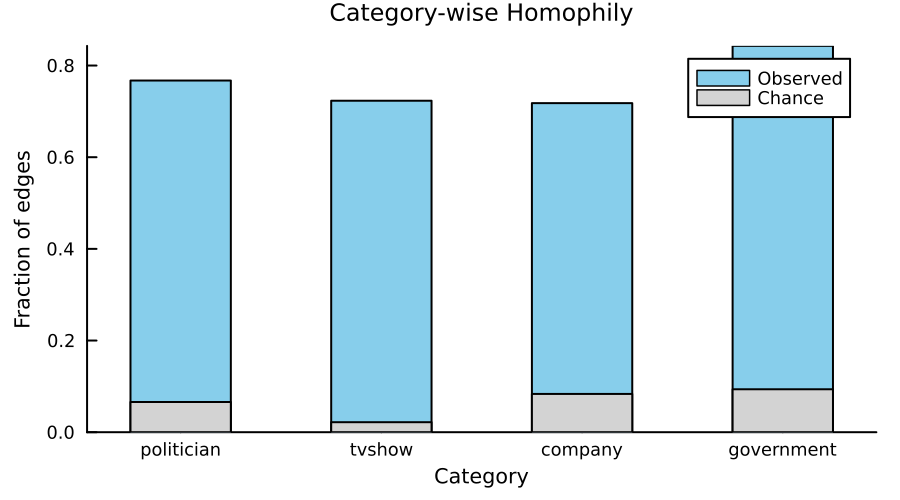

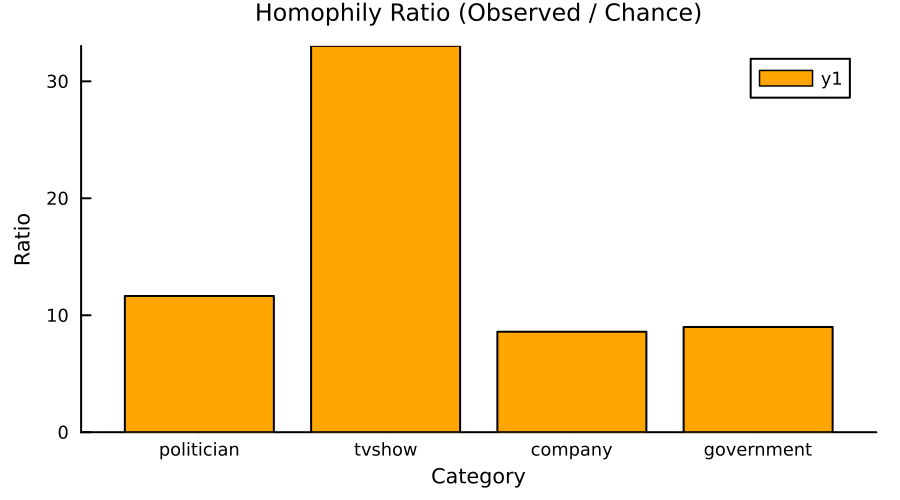

In [30]:
using Plots

# Category names and metrics from your homophily output
categories = ["politician", "tvshow", "company", "government"]
observed   = [0.7673, 0.7233, 0.718, 0.8429]
chance     = [0.0659, 0.0219, 0.0836, 0.0937]

# Calculate ratio (Observed / Chance)
ratios = [o/c for (o,c) in zip(observed, chance)]

default(
    size = (450, 250),
    titlefont = font(8),
    guidefont = font(7),
    tickfont = font(6),
    legendfont = font(6)
)

# Plot 1: Observed vs Chance Homophily
p1 = bar(categories, [observed chance],
            label = ["Observed" "Chance"],
            title = "Category-wise Homophily",
            ylabel = "Fraction of edges",
            xlabel = "Category",
            legend = :topright,
            bar_width = 0.5,
            color = [:skyblue :lightgray])

# Plot 2: Homophily Ratio
p2 = bar(categories, ratios,
            title = "Homophily Ratio (Observed / Chance)",
            ylabel = "Ratio",
            xlabel = "Category",
            color = :orange)

display(p1)
display(p2)

## Structural Bridge

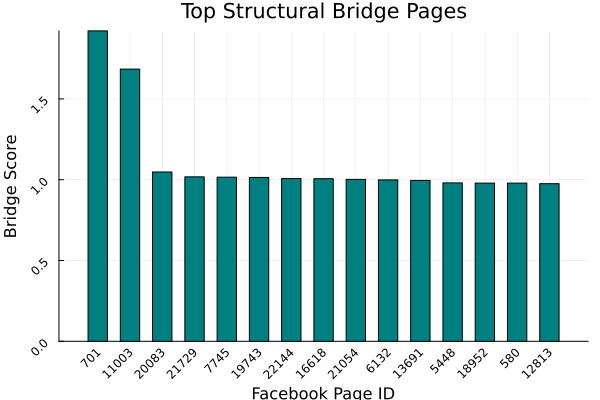

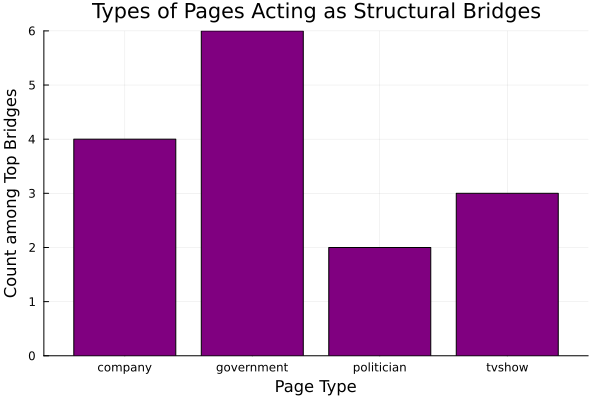

In [ ]:
using Plots, StatsPlots, DataFrames

df = result.df
top = result.top

# Top Bridge Pages (which pages connect communities)
p1=bar(
    string.(top.original_id),
    top.bridge_score,
    xlabel="Facebook Page ID",
    ylabel="Bridge Score",
    title="Top Structural Bridge Pages",
    rotation=45,
    legend=false,
    bar_width=0.6,
    color=:teal
)
display(p1)
#  Page Type Distribution (what kinds of pages are they)
grouped = combine(groupby(top, :page_type), nrow => :count)

@df grouped bar(
    :page_type,
    :count,
    xlabel="Page Type",
    ylabel="Count among Top Bridges",
    title="Types of Pages Acting as Structural Bridges",
    color=:purple,
    legend=false
)


## Structural Balance

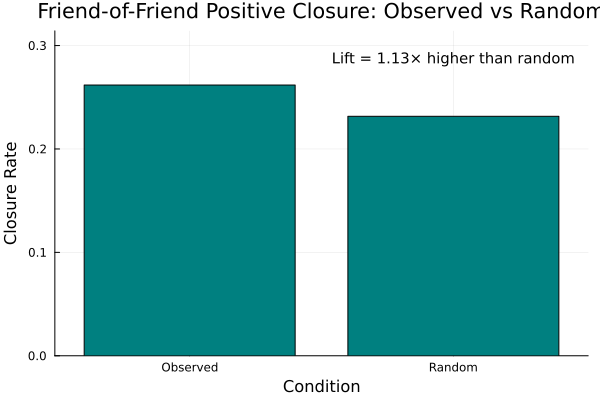


Plotting Observed vs Random Positive Closure Rate...


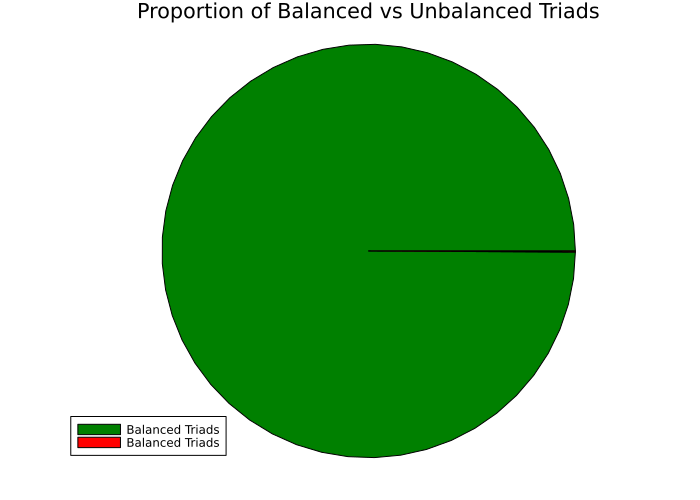

In [9]:
using Plots, DataFrames

obs = balance_stats.fof_pos_closure
rand_mean = balance_stats.fof_baseline_mean
lift = balance_stats.fof_lift
bal_ratio = balance_stats.balance_ratio

println("\nPlotting Observed vs Random Positive Closure Rate...")

bar(
    ["Observed", "Random"],
    [obs, rand_mean],
    xlabel="Condition",
    ylabel="Closure Rate",
    title="Friend-of-Friend Positive Closure: Observed vs Random",
    color=[:teal :gray],
    legend=false,
    ylim=(0, max(obs, rand_mean) * 1.2)
)

annot = "Lift = $(round(lift, digits=2))× higher than random"
annotate!(1.5, max(obs, rand_mean)*1.1, text(annot, 10, :black))
display(current())


gr()

balance_ratio = bal_ratio
unbalanced_ratio = 1 - balance_ratio

data = [balance_ratio, unbalanced_ratio]


labels = ["Balanced Triads" "Unbalanced Triads"] 
colors = [:green, :red]


pie(
    data;
    label = labels,      
    color = colors,
    title = "Proportion of Balanced vs Unbalanced Triads",
    legend = true,
    size = (700, 500)
)

## Discussion

**Research Question 1:**  
*Do Facebook pages tend to connect more often with other pages from the same category (e.g., politician-to-politician, brand-to-brand)?*  

- Yes, the Facebook pages do tend to connect more often with pages from the same category, demonstrating strong homophily. The observed homophily was **0.8853**, which is over 3x higher than the expected random  chance homophily (**0.2651**). 
- On a category-level, TV Shows are the most internally connected (~33 times more likely than random), with Politicians, Companies, and Government pages also showing strong within-group connections (~8-12 times more likely than random). Overall, this suggests that the network is highly clustered by page type, with limited cross-category interactions.


**Research Question 2:**  
*Which Facebook pages connect different types of communities together (acting as structural bridges), and what kind of pages are they?*  
- The top structural bridge is the official **Facebook** company page (node 701), with the highest bridge score **(1.92)**, indicating it plays a central role in linking the different categories. The second strongest bridge is **Barack Obama's** page (node 11003), a politician who connects across multiple community types, indicating widespread engagment beyond the political sphere.
- Among the top 15 structural bridges, the most common page types were Government pages (6), followed by Companies (4), TV Shows (3), and Politicians (2). However, after the top two, most nodes show similar and much lower bridge scores (about 1.0), suggesting that only a few key pages are truly acting as global connectors, while the rest serve mainly as localized bridges within their own communities. 
- Overall, this pattern shows that a small number of highly influential pages maintain the global connectivity of the Facebook network. 

**Research Question 3:**  
*Does the network show signs of structural balance — for example, do pages that both like a third page also tend to like each other?*  
- Yes, the network shows clear signs of structural balance. Among all "friend-of-friend" pairs, about **26.18%** also like each other, compared to **23.2%** expected by random chance. This represents a **1.13x higher closure rate** (Z=7.63), indicating that pages sharing mutual interests are significantly more likely to connect directly. 
- While only about one in four potential triads close, those that do form are almost always consistent and positive (since we do not have negative ties in this network), reflecting a moderate tendency toward triadic closure and a high degree of structural balance overall. 


# Conclusion

The Facebook Page-Page network reveals clear evidence of strong homophily, with pages overwhelmingly connecting to others of the same category. While a small number of highly influential pages serve as bridges between otherwise distinct communities, the overall network remains highly segmented by category. Additionally, the network exhibits a high degree of structural balance, with the absence of negative ties. This means that though, "friends of friends" do not always connect, when they do, the relationships are consistent and mutually reinforcing. 

Together, these findings suggest that the Facebook Page-Page system is characterized by dense, internally cohesive communities with limited cross-category interactions. 

However, several limitations need to be acknowledged. 
1. The dataset only includes mutual likes, excluding one-way relationships that would normally influence a network structure like this.
2. It’s a **static network** from 2017, so it doesn’t show how the connections change over time.  
3. There are only **four categories** (politician, government, company, TV show), whereas in reality, many pages may fit into more specific or overlapping classifications.  
4. The data doesn’t include **how strong** each connection is — just whether it exists or not.  